In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn import linear_model
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error
from statsmodels.regression.quantile_regression import QuantReg

In [120]:
import scipy.stats as stats

In [121]:
import scipy as sp

In [2]:
from sklearn.model_selection import train_test_split

In [178]:
import pickle

In [5]:
df = pd.read_csv('data/train/train.csv')

In [7]:
df['GHI'] = df['DHI']+df['DNI']

In [57]:
x = df[['DHI','DNI','GHI','WS','RH','T'] ]
y = df[['TARGET']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2) 
# random sampling

In [58]:
# from sklearn.linear_model import LinearRegression

mlr = linear_model.LinearRegression()
mlr.fit(x_train, y_train) 

LinearRegression()

In [160]:
mlr.predict(np.array([
                      [0,0,0,3.3,81.25,-5], 
                      [0,0,0,3.3,81.25,-5]                        
                     ]) ) #exam input

array([[-4.37972389],
       [-4.37972389]])

In [59]:
y_predict = mlr.predict(x_test)
# model = LinearRegression(fit_intercept=True) default 
# fit_intercept = 상수항 여부

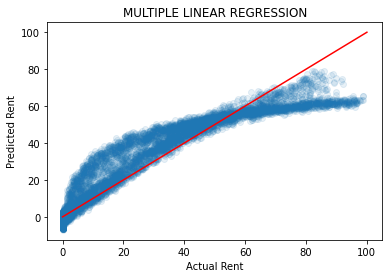

In [60]:
plt.scatter(y_test, y_predict, alpha=0.1)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.plot([0,100],[0,100],color='red')
plt.show()

In [61]:
print("R squared : ",mlr.score(x_train,y_train))

R squared :  0.8989720558721727


In [62]:
print("R squared : ",mlr.score(x_test,y_test))

R squared :  0.9037055402928881


In [63]:
### about this model

In [64]:
mlr.coef_
# x_train.columns
for col,coef in zip(x_train.columns,list(mlr.coef_[0]) ):
    print(f"{col} : {coef}")
print("constant term : ",mlr.intercept_[0])

DHI : 11487065340.536053
DNI : 11487065340.479563
GHI : -11487065340.43084
WS : -0.029638879869185706
RH : -0.02630370904589763
T : 0.2306105976554477
constant term :  -0.991686240460453


In [77]:
y_train_predict = mlr.predict(x_train)

In [81]:
y_train_predict = pd.DataFrame(y_train_predict)

In [94]:
y_train.index = list(range(len(y_train)))

In [100]:
y_train_predict.columns =['TARGET']

#### residual

In [114]:
res = y_train_predict - y_train

In [112]:
# 자유도 n-k (sample - columns - 1(constant 한개) ) 
std_err = np.sqrt( ((y_train_predict - y_train)**2).sum()/ (len(y_train)-len(y_train.columns)-1 )  )
print('std of err : ',std_err ) 

std of err :  TARGET    8.183804
dtype: float64


In [80]:
y_predict = pd.DataFrame(y_predict)

### nomality-test

{'whiskers': [<matplotlib.lines.Line2D at 0x1435ffbb520>,
 'caps': [<matplotlib.lines.Line2D at 0x1435ff9e340>,
 'boxes': [<matplotlib.lines.Line2D at 0x1435ffbba60>],
 'medians': [<matplotlib.lines.Line2D at 0x1435ffaa400>],
 'fliers': [<matplotlib.lines.Line2D at 0x143603fb4f0>],
 'means': []}

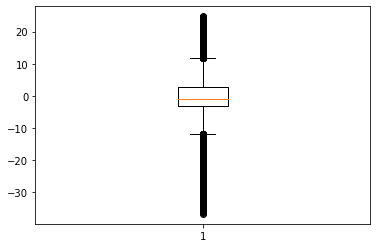

In [117]:
plt.boxplot(res)

#### shit...tail is too thick...

#### Q-Q plot

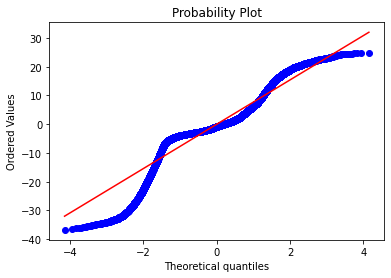

In [127]:
sp.stats.probplot(res['TARGET'].to_numpy(), plot=plt)
plt.show()

#### ... pass anyway

### find each quantile-value ( using Normal distribution assumption .. )

In [119]:
# mlr + nom-quant

LinearRegression()

In [130]:
res_nom = stats.norm(loc=0, scale=std_err)

In [131]:
nd =stats.norm(0,1)

### cdf : cumulative distribution function
### ppf : inverse cumulative distribution function

In [169]:
quant9 = list(map(lambda x : list(res_nom.ppf(0.1*x))[0] ,range(1,10) 
                  )) 
quant9

[-10.487967011755797,
 -6.887663338271465,
 -4.29159108856658,
 -2.0733430722961335,
 0.0,
 2.073343072296136,
 4.291591088566584,
 6.887663338271466,
 10.487967011755797]

In [198]:
def qr_model(x):
    return mlr.predict(x) + quant9

In [199]:
mlr.predict(x_test)

array([[-4.37972389],
       [34.49396392],
       [-3.99219228],
       ...,
       [-2.35250929],
       [-1.14732811],
       [ 1.16400069]])

In [200]:
q_rmodel(x_test)

array([[-14.8676909 , -11.26738723,  -8.67131498, ...,  -0.0881328 ,
          2.50793945,   6.10824312],
       [ 24.00599691,  27.60630059,  30.20237284, ...,  38.78555501,
         41.38162726,  44.98193094],
       [-14.48015929, -10.87985561,  -8.28378336, ...,   0.29939881,
          2.89547106,   6.49577474],
       ...,
       [-12.8404763 ,  -9.24017263,  -6.64410038, ...,   1.9390818 ,
          4.53515405,   8.13545772],
       [-11.63529512,  -8.03499145,  -5.4389192 , ...,   3.14426298,
          5.74033523,   9.3406389 ],
       [ -9.32396632,  -5.72366265,  -3.1275904 , ...,   5.45559178,
          8.05166403,  11.6519677 ]])

In [201]:
with open('q-reg_model.pkl','wb') as f:
    pickle.dump(qr_model,f)

### validate coefficients 